# TENSORFLOW SERVING

**Warning: Tập tin notebook này được run trên Google Colab**.

Model phân loại clothing, được train trên bộ dữ liệu [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), và sau đó sử dụng TensorFlow Serving cho request.

Do đây là minh họa cho TensorFlow Serving nên phần tiền xử lí, thuật toán train,... chỉ đơn giản sử dụng `tf.keras`

### Các thư viện cần thiết

In [1]:
# Don't use python3
import sys
assert sys.version_info.major == 3, 'Not running Python 3. You should change runtime type'

# Check run in Colab
try:
  import colab
  !pip install -Uq grpcio==1.26.0
except:
  pass

# Import important library
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

## 01. Tạo, train và save model:

**Load Fashion MNIST:**
- 70_000 images.
- 28 x 28 pixels.
- 10 categories.

In [2]:
# Load dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4422102/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


**Train model sử dụng CNN đơn giản:**
- Model thực hiện 5 epochs.
- Sử dụng metrics là accuracy.
- Có thể thấy độ chính xác của model trên tập test sau khi train là khá tốt.

In [3]:
# Create CNN model
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

# Hyperparameter
testing = False
optimizer = 'adam'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [keras.metrics.SparseCategoricalAccuracy()]
epochs = 5

# Fit, predict and evaluate model
model.compile(optimizer='adam', loss=loss, metrics=metrics)
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 17s 3ms/step - loss: 0.5213 - sparse_categorical_accuracy: 0.8193
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3818 - sparse_categorical_accuracy: 0.8684
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 

**Save model dưới dạng `SavedModel` với version xác định ở thư mục _/tmp_ với version là "1"**

In [4]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors and stored with the default serving key
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1




Saved model:
total 112
drwxr-xr-x 2 root root  4096 Apr  9 13:12 assets
-rw-r--r-- 1 root root    57 Apr  9 13:12 fingerprint.pb
-rw-r--r-- 1 root root  8757 Apr  9 13:12 keras_metadata.pb
-rw-r--r-- 1 root root 89006 Apr  9 13:12 saved_model.pb
drwxr-xr-x 2 root root  4096 Apr  9 13:12 variables


**Kiểm tra model đã được save sử dụng `saved_model_cli`**:
- Ở signature_def `serving_default` ta có thể thấy cấu trúc (type, shape,...) của inputs và outputs của method `predict` của model

In [5]:
!saved_model_cli show --dir {export_path} --all

2023-04-09 13:12:20.139358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
T

## 02. Serve model sử dụng TensorFlow Serving:

**Thêm package TensorFlow Serving**

In [6]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [7]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  48245      0 --:--:-- --:--:-- --:--:-- 48245
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:4 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [340 B]
Get:5 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [348 B]
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease


**Cài đặt TensorFlow Serving**

In [8]:
# Tensorflow Serving >2.9.0 required `GLIBC_2.29` and `GLIBCXX_3.4.26`. Currently colab environment doesn't support latest version of`GLIBC`,so workaround is to use specific version of Tensorflow Serving `2.8.0` to mitigate issue.
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb'
!dpkg -i tensorflow-model-server_2.8.0_all.deb
!pip3 install tensorflow-serving-api==2.8.0

--2023-04-09 13:12:29--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.125.128, 142.250.136.128, 142.250.148.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.125.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340152790 (324M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 324.39M   266MB/s    in 1.2s    

2023-04-09 13:12:30 (266 MB/s) - ‘tensorflow-model-server_2.8.0_all.deb’ saved [340152790/340152790]

Selecting previously unselected package tensorflow-model-server.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-model

**Run TensorFlow Serving với các thuộc tính sau:**
- `port` và `rest_api_port`: là port cho lần lượt gRPC và REST API.
- `model_name`: Tên của model, sẽ được dùng khi gọi API.
- `model_base_path`: Đường dẫn để save model.


In [9]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [10]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [11]:
!tail server.log

**Request 2 example đầu tiên và 2 example bất kì trong tập test đến model:**

In [12]:
!pip install -q requests
import random
import json
import requests

# Show model with title
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

# Input for request (data include 4 example: 2 examples at the first with 2 random examples)
headers = {"content-type": "application/json"}

index_data = [0, 1]
instances = test_images[0:2].tolist()

rand = random.randint(0,len(test_images)-1)
index_data.append(rand)
instances.append(test_images[rand].tolist())

rand = random.randint(0,len(test_images)-1)
index_data.append(rand)
instances.append(test_images[rand].tolist())

data = json.dumps({"signature_name": "serving_default", "instances": instances})

- Request đến model mới nhất có thể chỉ rõ version của model mới nhất hoặc không để version:
    - Kết quả hiện thị giữa thực sự và dự đoán trên 4 example của tập test.
    - Có thể thấy model khá tốt.

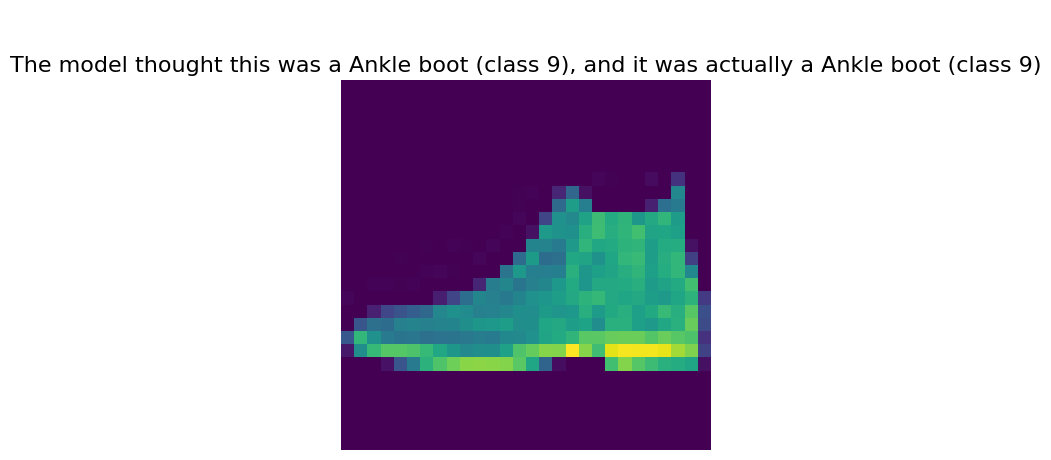

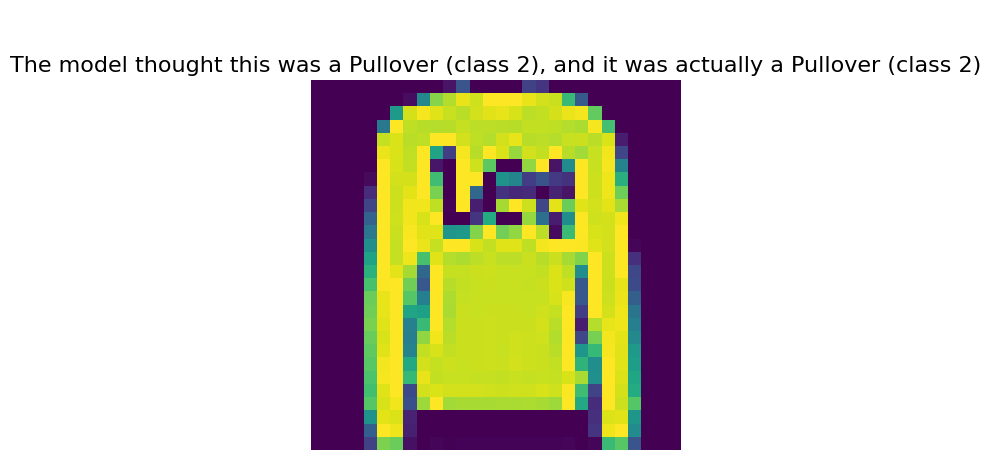

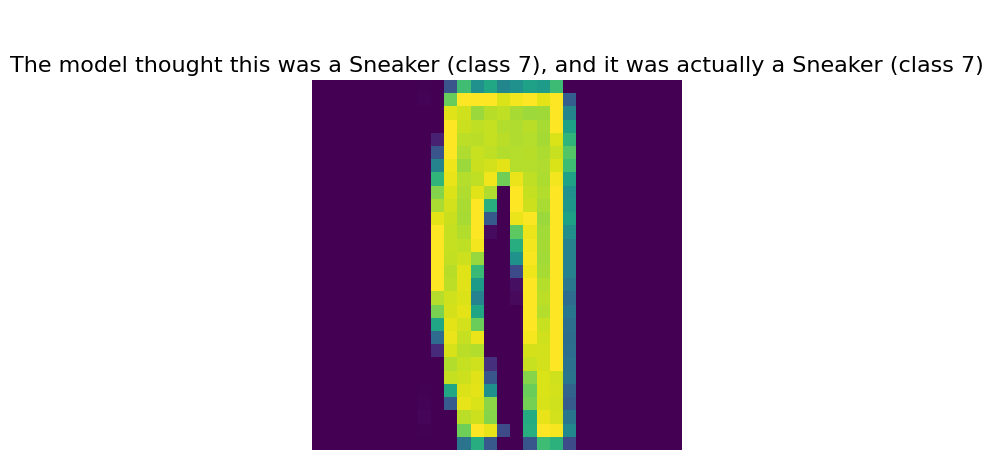

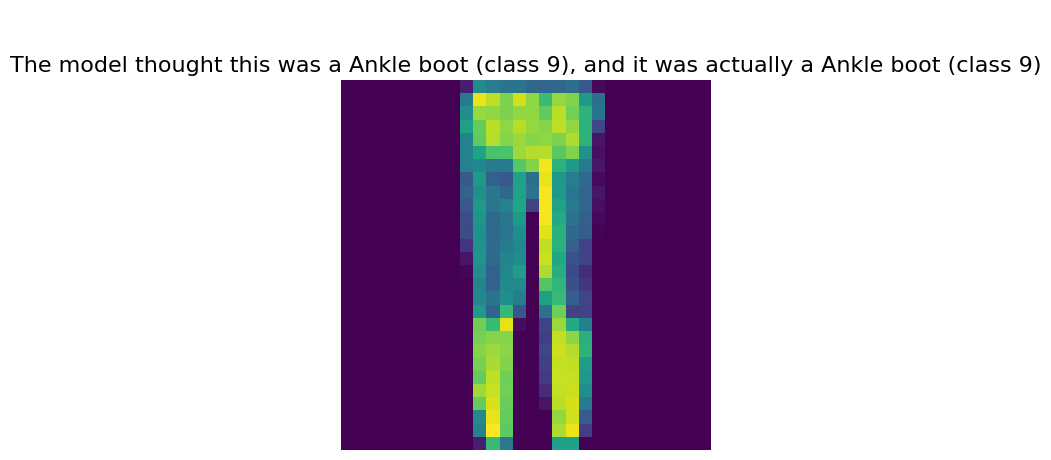

In [13]:
# Requests by use POST to lastest model and take response
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

# Show result of predicts
for i in range(0,4):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[index_data[i]]], test_labels[index_data[i]]))

- Request đến model xác định cần phải chỉ rõ version của model đó:
    - Kết quả hiện thị giữa thực sự và dự đoán trên 4 example của tập test.
    - Có thể thấy model khá tốt. 

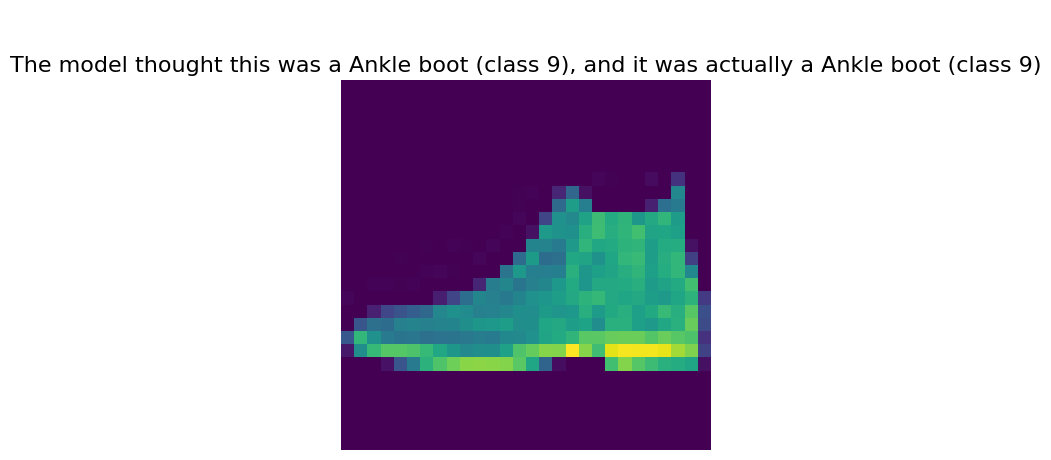

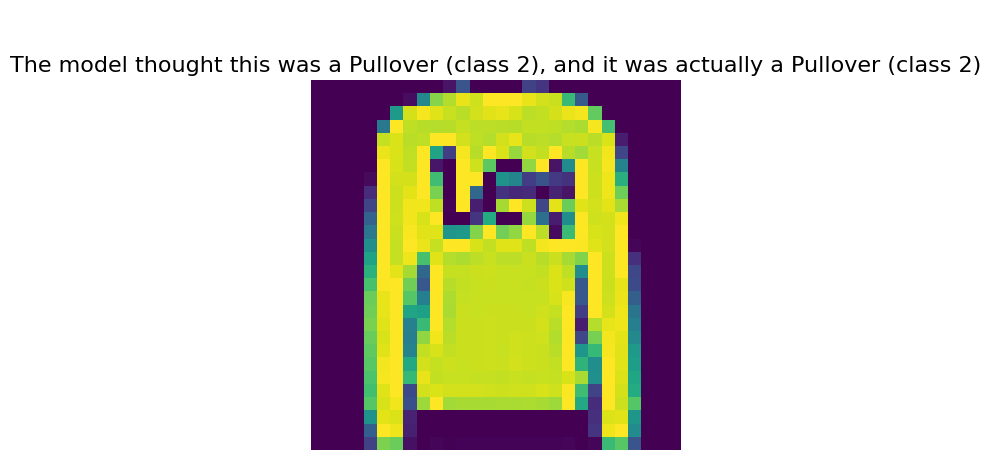

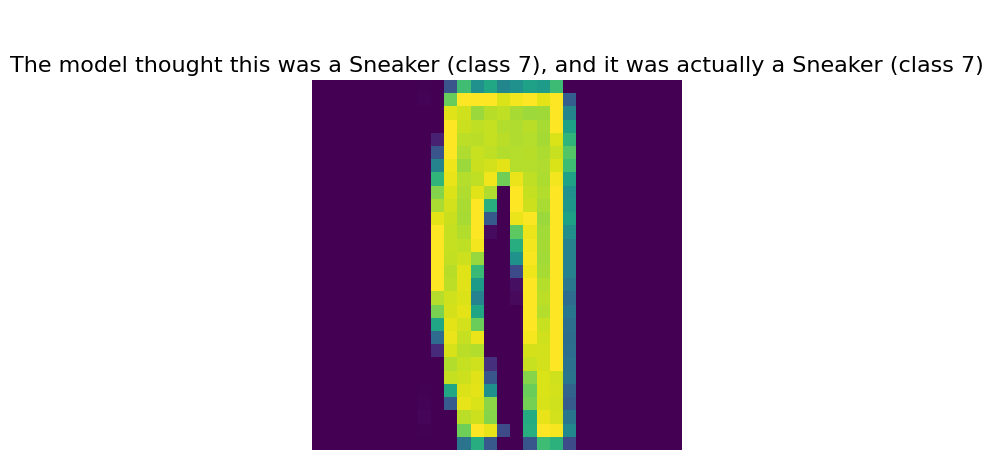

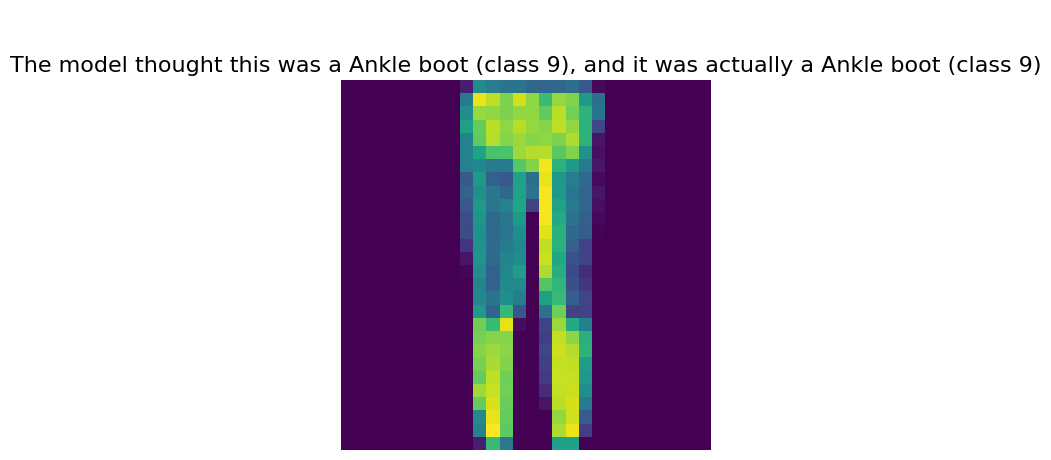

In [14]:
# Requests by use POST to lastest model and take response
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

# Show result of predicts
for i in range(0,4):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    class_names[np.argmax(predictions[i])], np.argmax(predictions[i]), class_names[test_labels[index_data[i]]], test_labels[index_data[i]]))

- Xem các version của model:
    - Có thể thấy model có 1 version đánh số "1" chính là model vừa được train.

In [15]:
!curl localhost:8501/v1/models/fashion_model

{
 "model_version_status": [
  {
   "version": "1",
   "state": "AVAILABLE",
   "status": {
    "error_code": "OK",
    "error_message": ""
   }
  }
 ]
}
